In [1]:
# core stuff for gravann
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device) 


Will use device  cpu


/home/moritz/Gadgets/anns4geodesy/gravann/_utils.py:80: UserWarning: Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
  warnings.warn(


In [2]:
from spiceypy import spiceypy as spice
from spiceypy.utils.exceptions import SpiceNOTDISJOINT

In [3]:
from calendar import month_abbr
from astropy.time import Time, TimeDelta
import datetime

In [4]:
# Pebbles
spice.furnsh("/home/moritz/Downloads/particles_pub_03Mar2020.bsp")

In [5]:
# Other bennu related stuff
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/bennu_v15.tpc")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/pck00010.tpc")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_v14.tf")
# leap seconds kernel
spice.furnsh('/home/moritz/Downloads/naif0012.tls')
spice.furnsh('/home/moritz/Downloads/pck00010.tpc')

In [6]:
# Other Solar system Ephemerides
spice.furnsh("/home/moritz/Downloads/de430.bsp")
# Bennu Ephemerides
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/bennu_refdrmc_v1.bsp")
# Bennu DSK
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/bennu_g_00880mm_alt_obj_0000n00000_v020.bds")

In [7]:
# Osiris Rex
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_160909_171201_170830_od023_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_170501_180710_171005_od027_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_170923_180710_180125_od030_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_170923_180710_180321_od031_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_180301_181201_180921_od044_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_180801_190302_181218_od077_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_181203_190302_190104_od085_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_181231_190305_190215_od099_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190201_190327_190315_od110_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190301_190424_190412_od125_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190401_190522_190508_od137_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190426_190605_190522_od143_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190511_190619_190603_od148_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190601_190625_190614_od154_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190612_190917_190730_od170_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190712_190917_190814_od175_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190809_191008_190923_od182_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190809_191015_191004_od187_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190915_191029_191014_od191_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191001_191105_191021_od194_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191015_191112_191030_od198_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191027_200101_191104_od200_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191101_200225_200214_od223_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_200127_200324_200311_od232_v1.bsp")

In [8]:
bennu_id = spice.bodn2c("Bennu")
sun_id = spice.bodn2c("Sun")

In [9]:
lines = []
with open("/home/moritz/Downloads/particle-comments", "r") as f:
    for line in f:
        lines.append(line)

In [10]:
bodyindices = [i for i in range(len(lines)) if "BODIES" in lines[i]]

In [11]:
monthnames = [elem.upper() for elem in month_abbr]
def dateToIso(noniso: str):
    year, textmonth, day, clock = noniso.split()
    month = monthnames.index(textmonth)
    return year+"-"+str(month)+"-"+day+" "+clock

In [12]:
bodies = dict()
allIDs = []
for index in bodyindices:
    objids = lines[index].split("=")[-1].split(",")
    for elem in objids:
        objid = int(elem.strip())
        begin = Time(dateToIso(lines[index+1].strip().split("=")[-1].strip()))
        end = Time(dateToIso(lines[index+2].strip().split("=")[-1].strip()))
        allIDs.append(objid)
        bodies[objid] = (begin, end)

In [13]:
# Encoding choosen
encoding = gravann.direct_encoding()

# For "normal" training
model = gravann.init_network(encoding, model_type="siren")

In [14]:
model.load_state_dict(torch.load("models/siren_acc_bennu_hf-10k-300k.mdl", map_location=torch.device('cpu')))

<All keys matched successfully>

Sampling points...: 2776it [00:01, 2749.26it/s]                          


<IPython.core.display.Javascript object>


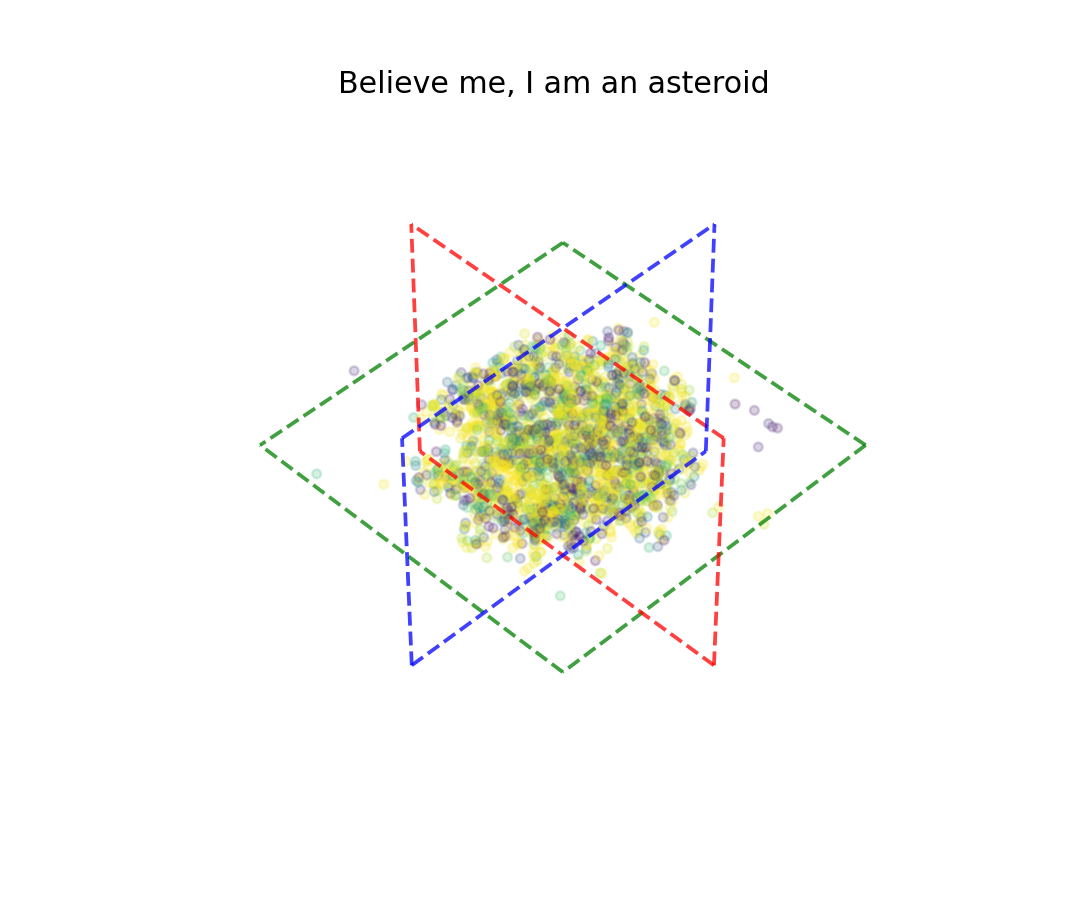

Text(0.5, 0.92, 'Believe me, I am an asteroid')

In [15]:
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=10)
plt.title("Believe me, I am an asteroid")

In [16]:
L_units = 352.1486930549145
T_units = 2987.9522951342647
a_units = L_units / T_units**2

integrator = gravann.ACC_trap
N_integration = 30000

In [17]:
def acceleration(spice_id: int, t: Time, dt: float):
    def vel(x: Time):
        v = np.array(spice.spkez(spice_id, spice.str2et(x.iso), "J2000", abcorr="NONE", obs=bennu_id)[0][3:])
        return v
    
    h = datetime.timedelta(seconds=dt)
    
    # using five point stencil.
    # Note that the ephemerides functions take input in days, but velocities are returned in km/s.
    accel = (vel(t-2*h)+8*vel(t+h)-8*vel(t-h)-vel(t+2*h))/(12*dt) * 1000
        
    return accel

In [18]:
# get ephemerides at start-time, rotate into Bennu frame, compute acceleration as predicted by neural network
def propagate_pebble(spice_id: int, steps: int, start_offset: TimeDelta, steptime: TimeDelta,
                     integrator, model, encoding, N_integration: int):
       
    start_time, end_time = bodies[spice_id]
    adjusted_start_time = start_time + start_offset
    max_steps = (end_time - adjusted_start_time) / steptime
    if steps > max_steps:
        print(steps, "steps of time", steptime, "requested, but trajectory fits only", max_steps)
        steps = max_steps
    if max_steps <= 0:
        raise ValueError("No usable trajectory left for" + str(spice_id) + " with offset " + start_offset)
        
    initial_eph = np.array(spice.spkez(spice_id, spice.str2et(adjusted_start_time.iso), "J2000", abcorr="NONE", obs=bennu_id)[0])*1000
    initial_pos = initial_eph[0:3]
    initial_vel = initial_eph[3:6]
    eph = initial_eph
    pos = initial_pos
    vel = initial_vel
    ephs = list()
    times = list()
    
    for i in range(steps):
        t = adjusted_start_time + i*steptime
        ephs.append(eph)
        times.append(t)
        
        # Get time-varying rotation matrix
        # TODO: If doing this for many pebbles, it could be faster to synchronize them and only compute the
        # matrix once for every time step.
        TIPM = spice.tipbod( "J2000", bennu_id, spice.str2et(t.iso))
        
        # Rotate eph into body-fixed frame
        pos_bennu_frame = np.array(np.dot(np.matrix(TIPM), pos))[0]
        
        # Convert into normalized units
        pos_bennu_units = pos_bennu_frame / L_units
        
        # Call neural network to predict acceleration at current position
        predicted_acc = integrator(torch.from_numpy(pos_bennu_units), model, encoding, N=N_integration)[0].detach()
        
        # Convert back into SI units
        acc_SI_units = predicted_acc * a_units
        #print("Converted acceleration from", predicted_acc, "to", acc_SI_units)
        
        # Rotate back into inertial frame
        I_TIPM = np.matrix(spice.invert(TIPM)) # TODO: maybe a numpy conversion would be faster?
        acc_inertial = np.array(np.dot(np.matrix(I_TIPM), acc_SI_units))[0]
        acc_measured = acceleration(spice_id, t, 0.1)
        print(np.linalg.norm(acc_inertial - acc_measured) / np.linalg.norm(acc_measured))
        acc = acc_inertial
        print(acc_inertial, acc_measured)
        
        # Propagate time step #TODO: add solar pressure acceleration
        # TODO: I think there might be an issue here 
        dt = steptime.sec
        pos_new = np.array(pos + dt * vel + 0.5*acc*dt*dt)
        vel_new = np.array(vel + acc*dt)
        eph_new = np.concatenate((pos_new, vel_new))
               
        pos = pos_new
        vel = vel_new
        eph = eph_new
    
    return ephs, times

In [19]:
spice_id = -64000137
steps = 360
start_offset = datetime.timedelta(hours=1)
steptime = TimeDelta(datetime.timedelta(hours=0, minutes=0, seconds=20))
ephs, times = propagate_pebble(spice_id, steps, start_offset, steptime, integrator, model, encoding, N_integration)


0.9484624431447096
[ 1.80810088e-06  1.27621809e-06 -7.59920768e-07] [7.05599256e-06 4.77691833e-06 9.91530475e-06]
0.9493426494803395
[ 1.79137339e-06  1.24787010e-06 -7.57030675e-07] [6.99223397e-06 4.75714687e-06 9.85800750e-06]
0.9502204172702461
[ 1.77483720e-06  1.22009644e-06 -7.54161260e-07] [6.92933733e-06 4.73750646e-06 9.80127120e-06]
0.9510886413541738
[ 1.75898909e-06  1.19318978e-06 -7.51553425e-07] [6.86729051e-06 4.71799755e-06 9.74509158e-06]
0.9519549699000108
[ 1.74352758e-06  1.16698322e-06 -7.49126016e-07] [6.80607869e-06 4.69861965e-06 9.68946232e-06]
0.9528174457960523
[ 1.72834820e-06  1.14139665e-06 -7.46778759e-07] [6.74568511e-06 4.67937109e-06 9.63437471e-06]
0.9536712200348381
[ 1.71374936e-06  1.11660256e-06 -7.44650467e-07] [6.68609573e-06 4.66025076e-06 9.57982138e-06]
0.9545240425037482
[ 1.69946740e-06  1.09238412e-06 -7.42659908e-07] [6.62729992e-06 4.64125877e-06 9.52579764e-06]
0.9553739173111101
[ 1.68560582e-06  1.06878035e-06 -7.40846468e-07] [6.

1.0154928655314628
[ 1.33031873e-06  2.31876889e-07 -8.86054094e-07] [4.04373169e-06 3.65561744e-06 6.92431948e-06]
1.016851209250945
[ 1.33097528e-06  2.23219170e-07 -8.93076975e-07] [4.01641856e-06 3.64328595e-06 6.89400745e-06]
1.0182457649551462
[ 1.33223625e-06  2.14665751e-07 -9.00580634e-07] [3.98938783e-06 3.63103503e-06 6.86394057e-06]
1.0196611553738135
[ 1.33336877e-06  2.06052981e-07 -9.08082868e-07] [3.96263345e-06 3.61886214e-06 6.83411255e-06]
1.0211105897004817
[ 1.33481192e-06  1.97474084e-07 -9.15903062e-07] [3.93615084e-06 3.60676615e-06 6.80451951e-06]
1.022580836545072
[ 1.33622818e-06  1.88890080e-07 -9.23775823e-07] [3.90994084e-06 3.59475077e-06 6.77516673e-06]
1.0240870453624844
[ 1.33801542e-06  1.80327401e-07 -9.31992256e-07] [3.88399933e-06 3.58281490e-06 6.74605091e-06]
1.025625416735062
[ 1.33988846e-06  1.71747717e-07 -9.40395740e-07] [3.85830000e-06 3.57093704e-06 6.71713094e-06]
1.027198770132754
[ 1.34207398e-06  1.63186295e-07 -9.49107052e-07] [3.8329

1.3503903977050373
[ 2.24288856e-06 -7.66090066e-07 -2.79839788e-06] [2.63107009e-06 2.94517993e-06 5.24932210e-06]
1.3656198199195226
[ 2.28346175e-06 -8.00636447e-07 -2.88119220e-06] [2.61685719e-06 2.93712250e-06 5.23110275e-06]
1.3816584782026402
[ 2.32580620e-06 -8.36819207e-07 -2.96804127e-06] [2.60278853e-06 2.92913768e-06 5.21305270e-06]
1.3986378072094339
[ 2.37042784e-06 -8.74818914e-07 -3.05969354e-06] [2.58882947e-06 2.92119340e-06 5.19510784e-06]
1.4165906906145207
[ 2.41709305e-06 -9.14731487e-07 -3.15620922e-06] [2.57496661e-06 2.91326816e-06 5.17723695e-06]
1.4355440983210812
[ 2.46578243e-06 -9.56554503e-07 -3.25772566e-06] [2.56123150e-06 2.90540247e-06 5.15950809e-06]
1.455608570171195
[ 2.51693346e-06 -1.00041836e-06 -3.36484824e-06] [2.54760892e-06 2.89757957e-06 5.14189152e-06]
1.4769364110426233
[ 2.57096319e-06 -1.04676049e-06 -3.47832778e-06] [2.53409485e-06 2.88979586e-06 5.12438052e-06]
1.4996175812128623
[ 2.62792200e-06 -1.09582365e-06 -3.59855471e-06] [2.5

7.166552465018817
[-7.34652187e-06  8.65539101e-06  3.97402394e-05] [1.84867211e-06 2.46158053e-06 4.18666939e-06]
6.328979986553316
[-4.88094373e-06  8.30364229e-06  3.57356408e-05] [1.84051147e-06 2.45602036e-06 4.17484324e-06]
5.713710520874973
[-4.08054447e-06  8.37447972e-06  3.24721822e-05] [1.83240889e-06 2.45048783e-06 4.16308481e-06]
5.120489849613073
[-3.85071959e-06  8.47890136e-06  2.91964724e-05] [1.82436289e-06 2.44498159e-06 4.15139154e-06]
4.552817738515189
[-3.65085062e-06  8.35562741e-06  2.60961662e-05] [1.81637289e-06 2.43950152e-06 4.13976294e-06]
4.024752164180353
[-3.38096232e-06  7.99986942e-06  2.32879603e-05] [1.80843880e-06 2.43404821e-06 4.12819979e-06]
3.5502690293104333
[-3.07380822e-06  7.52750384e-06  2.08217574e-05] [1.80056009e-06 2.42862155e-06 4.11670175e-06]
3.1524676160887823
[-2.77920038e-06  7.06566588e-06  1.87793751e-05] [1.79273580e-06 2.42322081e-06 4.10526736e-06]
2.794067654491256
[-2.48589587e-06  6.57995907e-06  1.69698581e-05] [1.7849654

0.7718853482398838
[2.59623021e-07 3.71748086e-07 8.88693203e-07] [1.37994944e-06 2.12177413e-06 3.47972770e-06]
0.7764051976552081
[2.59848035e-07 3.61376996e-07 8.67794131e-07] [1.37479370e-06 2.11780576e-06 3.47163643e-06]
0.7808222826595672
[2.59932959e-07 3.51283509e-07 8.47498497e-07] [1.36966752e-06 2.11385543e-06 3.46358474e-06]
0.7850725035546436
[2.60004066e-07 3.41584504e-07 8.28014749e-07] [1.36457066e-06 2.10992308e-06 3.45557231e-06]
0.7891861163793051
[2.60004585e-07 3.32208007e-07 8.09238764e-07] [1.35950222e-06 2.10600758e-06 3.44759720e-06]
0.7931634555572142
[2.59965518e-07 3.23157238e-07 7.91143879e-07] [1.35446189e-06 2.10210873e-06 3.43965900e-06]
0.7970216505953173
[2.59876558e-07 3.14386630e-07 7.73664553e-07] [1.34945105e-06 2.09822890e-06 3.43176137e-06]
0.8007810133678476
[2.59708468e-07 3.05871260e-07 7.56711700e-07] [1.34446924e-06 2.09436759e-06 3.42390337e-06]
0.8044221212622314
[2.59500234e-07 2.97634140e-07 7.40345381e-07] [1.33950861e-06 2.09051310e-06

0.915626764963905
[2.34142508e-07 4.23956769e-08 2.78443235e-07] [1.06803467e-06 1.87218897e-06 2.97520528e-06]


In [20]:
for eph, t in zip(ephs, times):
    gt_eph = np.array(spice.spkez(spice_id, spice.str2et(t.iso), "J2000", abcorr="NONE", obs=bennu_id)[0])*1000
    pos_error = gt_eph[0:3] - eph[0:3]
    vel_error = gt_eph[3:6] - eph[3:6]
    print(np.linalg.norm(pos_error), np.linalg.norm(vel_error))

0.0 0.0
0.002474491275608693 0.00024717626432764174
0.009878713086312139 0.000492976326685393
0.022185281535421694 0.0007374145815819351
0.03936707823606412 0.000980503467083799
0.06139724865977135 0.001222257172048064
0.08824921225442942 0.001462689147712009
0.11989664152268437 0.0017018114813634041
0.15631346696690213 0.001939638084704173
0.19747388816520156 0.002176182125893464
0.24335235918276132 0.002411456077864351
0.29392359037911225 0.002645473321016227
0.3491625392860426 0.0028782453415253065
0.40904442586630757 0.0031097868047726316
0.47354469632212254 0.0033401061681801597
0.5426390502926954 0.003569220355365298
0.6163034678850696 0.0037971404474163605
0.6945141366606546 0.004023876622438906
0.7772474657201125 0.0042494418820456705
0.8644801553123836 0.00447384864312547
0.956189103149146 0.0046971082655701294
1.0523514558883171 0.004919233115656619
1.1529445839288501 0.005140233268972857
1.2579460835445107 0.005360121339837572
1.367333791802292 0.0055789088861033865
1.481085

225.65670577985858 0.08841216324840279
227.41502500594595 0.08847319158228156
229.174770268833 0.0885345065311149
230.93594228063728 0.08859609077132666
232.69854157580068 0.08865792939421896
234.4625685355296 0.08872000801182509
236.22802340421603 0.08878231386835092
237.994906308725 0.08884483577488124
239.7632172897426 0.08890756125539241
241.53295623070326 0.08897047751709274
243.3041229126556 0.08903357468099063
245.07671702065974 0.08909684205162761
246.85073813453343 0.08916026883147452
248.62618574445983 0.08922384647606811
250.40305925641042 0.0892875650919438
252.18135798499063 0.0893514157705037
253.9610811775066 0.08941539128858245
255.7422280049444 0.08947948222439307
257.5247975777974 0.08954368318908414
259.30878893365116 0.0896079838739795
261.0942010324457 0.08967237873244283
262.88103279037426 0.08973686098700437
264.6692830764875 0.08980142504383402
266.45895070071526 0.08986606324243647
268.2500344203198 0.08993077083729159
270.0425329461011 0.08999554102873876
271.